# Post-pandemic analysis of the New York City Subway

## Introduction
This project analyzes New York City subway ridership patterns following the onset of the COVID-19 pandemic. I aim to include weather and COVID-19 data to project recovery rates using three models.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Loading data from API with pagination
url = "https://data.ny.gov/resource/vxuj-8kew.json"
offset = 0
limit = 1000
data = []

while True:
    response = requests.get(url, params={"$limit": limit, "$offset": offset})
    if response.status_code != 200:
        break
    batch = response.json()
    if not batch:
        break
    data.extend(batch)
    offset += limit

# Converting to DataFrame
columns_to_keep = ['date', 'subways_total_estimated_ridership', 'subways_of_comparable_pre_pandemic_day']
df = pd.DataFrame(data)[columns_to_keep]

# Preview data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 3 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   date                                    1748 non-null   object
 1   subways_total_estimated_ridership       1748 non-null   object
 2   subways_of_comparable_pre_pandemic_day  1748 non-null   object
dtypes: object(3)
memory usage: 41.1+ KB


,date,subways_total_estimated_ridership,subways_of_comparable_pre_pandemic_day
0,2020-03-01T00:00:00.000,2212965,0.97
1,2020-03-02T00:00:00.000,5329915,0.96
2,2020-03-03T00:00:00.000,5481103,0.98
3,2020-03-04T00:00:00.000,5498809,0.99
4,2020-03-05T00:00:00.000,5496453,0.99


In [3]:
# Converting date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Converting relevant columns to numeric
columns_to_convert = [
    'subways_total_estimated_ridership',
    'subways_of_comparable_pre_pandemic_day'
]

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Dropping rows with missing essential data
df = df.dropna(subset=['subways_total_estimated_ridership', 'subways_of_comparable_pre_pandemic_day'])

In [4]:
# NOAA API configuration
noaa_token = 'QWkdHDKTvFauLZmHwDkldARPtWutUviP'  # Replace with your NOAA token
noaa_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
headers = {'token': noaa_token}

def fetch_weather_data(start_date, end_date, station_id="GHCND:USW00094728"):
    weather_data = pd.DataFrame()
    date_ranges = pd.date_range(start=start_date, end=end_date, freq='365D')  # Generate 1-year chunks
    date_pairs = [(date_ranges[i].strftime('%Y-%m-%d'), (date_ranges[i + 1] - timedelta(days=1)).strftime('%Y-%m-%d')) for i in range(len(date_ranges) - 1)]
    date_pairs.append((date_ranges[-1].strftime('%Y-%m-%d'), end_date))
    for start, end in date_pairs:
        for datatypeid in ['TMAX', 'TMIN', 'PRCP']:
            params = {
                'datasetid': 'GHCND',
                'stationid': station_id,
                'startdate': start,
                'enddate': end,
                'datatypeid': datatypeid,
                'units': 'metric',
                'limit': 1000
            }
            print(f"Requesting NOAA data with params: {params}")
            for attempt in range(3):
                response = requests.get(noaa_url, headers=headers, params=params)
                if response.status_code == 200:
                    temp_df = pd.DataFrame(response.json().get('results', []))
                    weather_data = pd.concat([weather_data, temp_df], ignore_index=True)
                    break
                elif response.status_code == 429:
                    print("Rate limit exceeded. Waiting 2 seconds before retrying.")
                    time.sleep(2)
                elif response.status_code == 503:
                    print("Server unavailable. Waiting 10 seconds before retrying.")
                    time.sleep(10)
                else:
                    print(f"Failed to fetch weather data for {datatypeid} ({start} to {end}): {response.status_code}")
                    print(f"Response content: {response.content}")
    return weather_data

# Fetching weather data
start_date = df['date'].min().strftime('%Y-%m-%d')
end_date = df['date'].max().strftime('%Y-%m-%d')
weather_df = fetch_weather_data(start_date=start_date, end_date=end_date)
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Pivoting weather data to have TMAX, TMIN, and PRCP as columns
weather_df = weather_df.pivot_table(index='date', columns='datatype', values='value').reset_index()
weather_df.head()

# Merging weather data with subway ridership data
df = df.merge(weather_df, on='date', how='left')

Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2020-03-01', 'enddate': '2021-02-28', 'datatypeid': 'TMAX', 'units': 'metric', 'limit': 1000}
Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2020-03-01', 'enddate': '2021-02-28', 'datatypeid': 'TMIN', 'units': 'metric', 'limit': 1000}
Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2020-03-01', 'enddate': '2021-02-28', 'datatypeid': 'PRCP', 'units': 'metric', 'limit': 1000}
Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2021-03-01', 'enddate': '2022-02-28', 'datatypeid': 'TMAX', 'units': 'metric', 'limit': 1000}
Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2021-03-01', 'enddate': '2022-02-28', 'datatypeid': 'TMIN', 'units': 'metric', 'limit': 1000}
Reque

In [5]:
# Loading NYC COVID-19 vaccination data
vaccine_url = 'https://raw.githubusercontent.com/nychealth/covid-vaccine-data/main/people/trends-byboro.csv'
vaccine_df = pd.read_csv(vaccine_url)
vaccine_df['DATE'] = pd.to_datetime(vaccine_df['DATE'])
vaccine_df = vaccine_df[['DATE', 'CITY_PERC_1PLUS']]
vaccine_df.rename(columns={'DATE': 'date', 'CITY_PERC_1PLUS': 'vaccine_coverage'}, inplace=True)
vaccine_df['vaccine_coverage'] = vaccine_df['vaccine_coverage'] / 100

# Loading NYC COVID-19 case data
cases_url = 'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/cases-by-day.csv'
cases_df = pd.read_csv(cases_url)
cases_df['date_of_interest'] = pd.to_datetime(cases_df['date_of_interest'])
cases_df = cases_df[['date_of_interest', 'ALL_CASE_COUNT_7DAY_AVG']]
cases_df.rename(columns={'date_of_interest': 'date', 'ALL_CASE_COUNT_7DAY_AVG': 'case_avg'}, inplace=True)

# Merging COVID-19 data with subway ridership data
df = df.merge(vaccine_df, on='date', how='left')
df = df.merge(cases_df, on='date', how='left')

In [6]:
df.head()

,date,subways_total_estimated_ridership,subways_of_comparable_pre_pandemic_day,PRCP,TMAX,TMIN,vaccine_coverage,case_avg
0,2020-03-01,2212965,0.97,0.0,6.7,-3.8,NaN,0.0
1,2020-03-02,5329915,0.96,0.0,14.4,4.4,NaN,0.0
2,2020-03-03,5481103,0.98,6.6,15.0,9.4,NaN,0.0
3,2020-03-04,5498809,0.99,0.0,13.3,7.2,NaN,0.0
4,2020-03-05,5496453,0.99,0.0,10.6,3.9,NaN,0.0


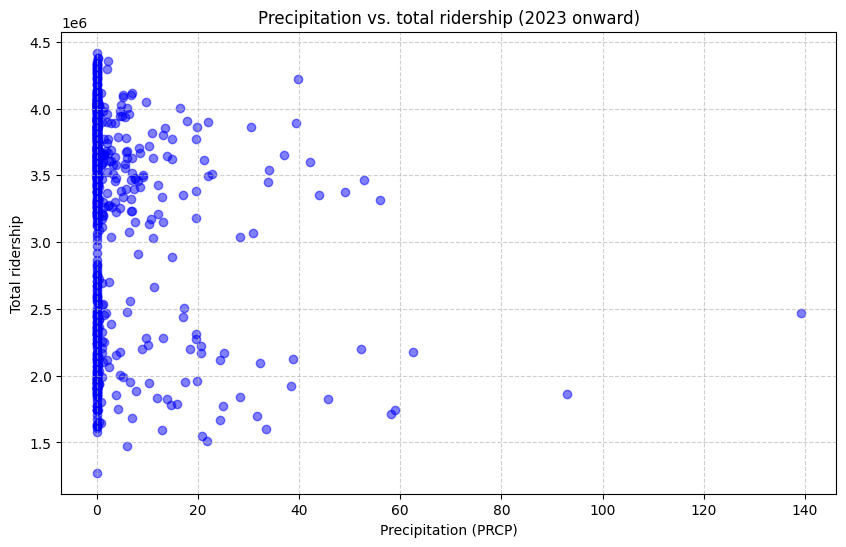

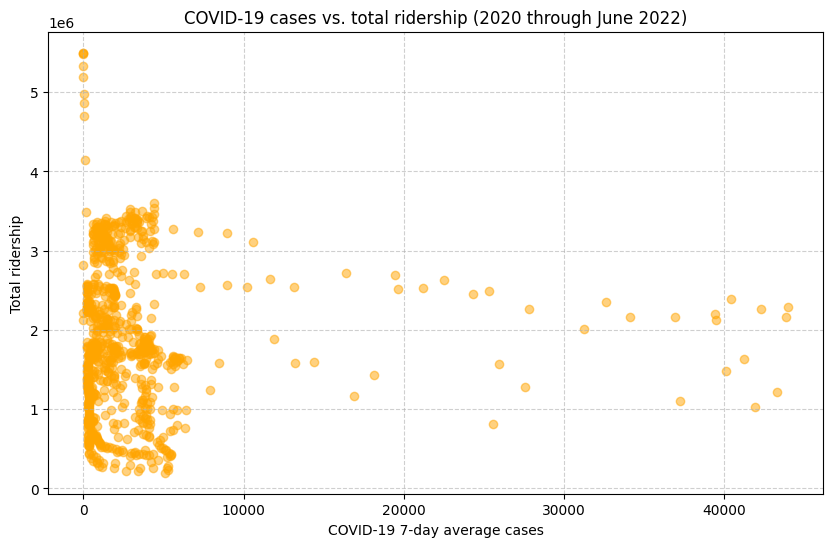

In [7]:
# Filter for 2023 onward for precipitation/ridership data
df_2023 = df[df['date'] >= '2023-01-01']

# Plot 1: Precipitation vs. Total Ridership (2023 onward)
plt.figure(figsize=(10, 6))
plt.scatter(df_2023['PRCP'], df_2023['subways_total_estimated_ridership'], alpha=0.5, color='blue')
plt.title('Precipitation vs. total ridership (2023 onward)')
plt.xlabel('Precipitation (PRCP)')
plt.ylabel('Total ridership')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Filter for 2020 to June 2022 for COVID-19 cases/ridership data
df_2020_2022 = df[(df['date'] >= '2020-01-01') & (df['date'] <= '2022-06-30')]

# Plot 2: COVID-19 Cases vs. Total Ridership (2020 through June 2022)
plt.figure(figsize=(10, 6))
plt.scatter(df_2020_2022['case_avg'], df_2020_2022['subways_total_estimated_ridership'], alpha=0.5, color='orange')
plt.title('COVID-19 cases vs. total ridership (2020 through June 2022)')
plt.xlabel('COVID-19 7-day average cases')
plt.ylabel('Total ridership')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [8]:
# Preparing data for predictive models
X = df[['TMAX', 'TMIN', 'PRCP', 'vaccine_coverage', 'case_avg']]
y = df['subways_of_comparable_pre_pandemic_day']

# Dropping rows with NaN values in features or target
X = X.dropna()
y = y.loc[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

# Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# ARIMA Model
y.index = df.loc[X.index, 'date']  # Ensure y has a DatetimeIndex
arima_model = ARIMA(y, order=(5, 1, 1))
arima_fit = arima_model.fit()

# Printing model performance
print("Linear regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Random forest MSE:", mean_squared_error(y_test, y_pred_rf))
print(arima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Linear regression MSE: 0.006223229119573399
Random forest MSE: 0.006046729154228857
                                         SARIMAX Results                                          
Dep. Variable:     subways_of_comparable_pre_pandemic_day   No. Observations:                 1003
Model:                                     ARIMA(5, 1, 1)   Log Likelihood                1158.796
Date:                                    Mon, 16 Dec 2024   AIC                          -2303.592
Time:                                            19:11:11   BIC                          -2269.224
Sample:                                        12-14-2020   HQIC                         -2290.531
                                             - 09-12-2023                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [9]:
import matplotlib.ticker as mtick

# Getting weather, vaccine, and COVID-19 case data for the forecast period
forecast_start_date = '2023-09-12'
forecast_end_date = datetime.now().strftime('%Y-%m-%d')

# Fetching updated weather data
print("\nFetching weather data...")
weather_df_new = fetch_weather_data(start_date=forecast_start_date, end_date=forecast_end_date)
weather_df_new['date'] = pd.to_datetime(weather_df_new['date'])
weather_df_new = weather_df_new.pivot_table(index='date', columns='datatype', values='value').reset_index()
print(f"Weather data size: {weather_df_new.shape}")

# Fetching updated vaccine data
print("\nFetching vaccine data...")
vaccine_url = 'https://raw.githubusercontent.com/nychealth/covid-vaccine-data/main/people/trends-byboro.csv'
vaccine_df_new = pd.read_csv(vaccine_url)
vaccine_df_new['DATE'] = pd.to_datetime(vaccine_df_new['DATE'])
vaccine_df_new = vaccine_df_new[['DATE', 'CITY_PERC_1PLUS']]
vaccine_df_new = vaccine_df_new.rename(columns={'DATE': 'date', 'CITY_PERC_1PLUS': 'vaccine_coverage'})
vaccine_df_new['vaccine_coverage'] = vaccine_df_new['vaccine_coverage'] / 100

# Fetching updated case data
print("\nFetching COVID-19 case data...")
cases_url = 'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/cases-by-day.csv'
cases_df_new = pd.read_csv(cases_url)
cases_df_new['date_of_interest'] = pd.to_datetime(cases_df_new['date_of_interest'])
cases_df_new = cases_df_new[['date_of_interest', 'ALL_CASE_COUNT_7DAY_AVG']]
cases_df_new = cases_df_new.rename(columns={'date_of_interest': 'date', 'ALL_CASE_COUNT_7DAY_AVG': 'case_avg'})

# Merging weather, vaccine, and case data
forecast_data = weather_df_new.merge(vaccine_df_new, on='date', how='left')
forecast_data = forecast_data.merge(cases_df_new, on='date', how='left')

# Filling missing values instead of dropping
forecast_data[['TMAX', 'TMIN', 'PRCP', 'vaccine_coverage', 'case_avg']] = forecast_data[['TMAX', 'TMIN', 'PRCP', 'vaccine_coverage', 'case_avg']].ffill().bfill()
X_forecast = forecast_data[['TMAX', 'TMIN', 'PRCP', 'vaccine_coverage', 'case_avg']]


Fetching weather data...
Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2023-09-12', 'enddate': '2024-09-10', 'datatypeid': 'TMAX', 'units': 'metric', 'limit': 1000}
Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2023-09-12', 'enddate': '2024-09-10', 'datatypeid': 'TMIN', 'units': 'metric', 'limit': 1000}
Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2023-09-12', 'enddate': '2024-09-10', 'datatypeid': 'PRCP', 'units': 'metric', 'limit': 1000}
Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2024-09-11', 'enddate': '2024-12-16', 'datatypeid': 'TMAX', 'units': 'metric', 'limit': 1000}
Requesting NOAA data with params: {'datasetid': 'GHCND', 'stationid': 'GHCND:USW00094728', 'startdate': '2024-09-11', 'enddate': '2024-12-16', 'datatypeid': 'TMIN', 'units': 'met

In [10]:
# Using Linear Regression and Random Forest to predict subway ridership
y_pred_lr_forecast = lin_reg.predict(X_forecast)
y_pred_rf_forecast = rf_reg.predict(X_forecast)

In [11]:
# Using ARIMA to forecast future subway ridership
forecast_periods = (pd.to_datetime(forecast_end_date) - pd.to_datetime(forecast_start_date)).days + 1
arima_forecast = arima_fit.forecast(steps=forecast_periods)

In [12]:
# Collecting actual subway ridership from the API
url_actual_ridership = "https://data.ny.gov/resource/vxuj-8kew.json"
response = requests.get(url_actual_ridership, params={"$where": f"date >= '{forecast_start_date}'", "$limit": 1000})
actual_ridership = pd.DataFrame(response.json())
actual_ridership['date'] = pd.to_datetime(actual_ridership['date'])
actual_ridership = actual_ridership[['date', 'subways_of_comparable_pre_pandemic_day']]

In [13]:
# Aligning predictions and actual data
results = forecast_data[['date']].copy()
results['Actual'] = actual_ridership.set_index('date').reindex(results['date'])['subways_of_comparable_pre_pandemic_day'].values
results['Actual'] = results['Actual'].astype(float)

print("\nResults (first 5 rows):")
print(results.head())


Results (first 5 rows):
        date  Actual
0 2023-09-12    0.70
1 2023-09-13    0.68
2 2023-09-14    0.70
3 2023-09-15    0.64
4 2023-09-16    0.76


In [14]:
results['Linear_Regression_Pred'] = y_pred_lr_forecast
results['Random_Forest_Pred'] = y_pred_rf_forecast

In [15]:
# Ensuring ARIMA forecast is aligned with results
arima_index = pd.date_range(start=forecast_start_date, periods=len(arima_forecast), freq='D')
arima_forecast_series = pd.Series(arima_forecast, index=arima_index)

# Aligning ARIMA forecast with results['date']
results['ARIMA_Pred'] = arima_forecast_series.reindex(results['date']).values  # Convert to percentages

In [16]:
# Dropping NaN rows to ensure clean MSE calculation
results_clean = results.dropna(subset=['Actual', 'Linear_Regression_Pred', 'Random_Forest_Pred', 'ARIMA_Pred'])
print(f"Clean results size: {results_clean.shape}")

Clean results size: (452, 5)


In [17]:
# Calculating MSE
if len(results_clean) > 0:
    mse_lr = mean_squared_error(results_clean['Actual'], results_clean['Linear_Regression_Pred'])
    mse_rf = mean_squared_error(results_clean['Actual'], results_clean['Random_Forest_Pred'])
    mse_arima = mean_squared_error(results_clean['Actual'], results_clean['ARIMA_Pred'])
    print(f"Linear regression MSE: {mse_lr}")
    print(f"Random forest MSE: {mse_rf}")
    print(f"ARIMA MSE: {mse_arima}")
else:
    print("No data available for MSE calculation.")


Linear regression MSE: 0.011282618972524663
Random forest MSE: 0.010016577411504432
ARIMA MSE: 0.010084859877260462


In [18]:
results.head(15)

,date,Actual,Linear_Regression_Pred,Random_Forest_Pred,ARIMA_Pred
0,2023-09-12,0.70,0.658228,0.7064,NaN
1,2023-09-13,0.68,0.657536,0.6406,0.687487
2,2023-09-14,0.70,0.659606,0.6922,0.657255
3,2023-09-15,0.64,0.664474,0.6483,0.676726
4,2023-09-16,0.76,0.659252,0.6221,0.698902
5,2023-09-17,0.78,0.649672,0.6420,0.675586
6,2023-09-18,0.61,0.628684,0.6841,0.676551
7,2023-09-19,0.72,0.660517,0.6190,0.683928
8,2023-09-20,0.72,0.658000,0.6198,0.677895
9,2023-09-21,0.72,0.660596,0.6237,0.674612


In [19]:
results['Actual'] = results['Actual'].rolling(window=14).mean()
results['Linear_Regression_Pred'] = results['Linear_Regression_Pred'].rolling(window=14).mean()
results['Random_Forest_Pred'] = results['Random_Forest_Pred'].rolling(window=14).mean()
results['ARIMA_Pred'] = results['ARIMA_Pred'].rolling(window=14).mean()


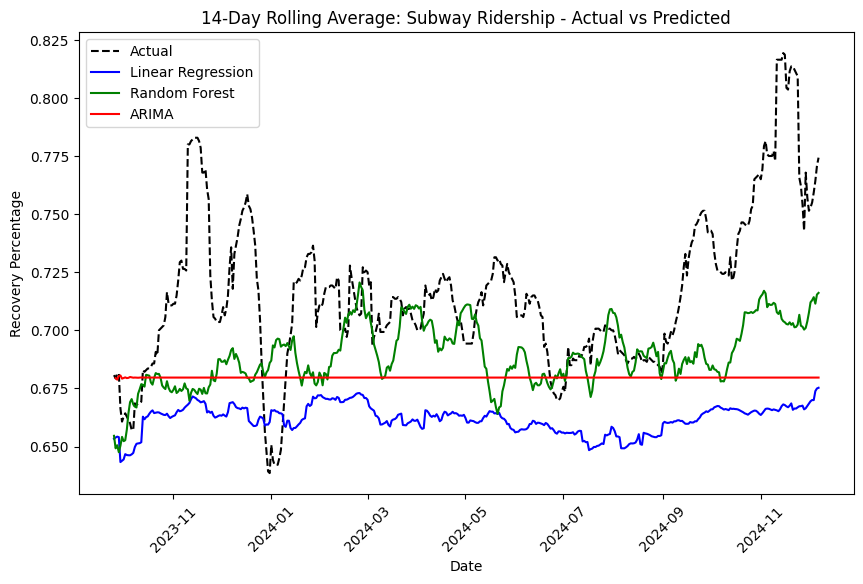

In [20]:
# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(results['date'], results['Actual'], label='Actual', color='black', linestyle='dashed')
plt.plot(results['date'], results['Linear_Regression_Pred'], label='Linear Regression', color='blue')
plt.plot(results['date'], results['Random_Forest_Pred'], label='Random Forest', color='green')
plt.plot(results['date'], results['ARIMA_Pred'], label='ARIMA', color='red')


plt.title('14-Day Rolling Average: Subway Ridership - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Recovery Percentage')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [21]:

# 1. Linear Regression
print("\n--- LINEAR REGRESSION MODEL ---")
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Print coefficients and intercept
print(f"Coefficients (beta values): {lin_reg.coef_}")
print(f"Intercept (beta_0): {lin_reg.intercept_}")

# Regression equation
regression_equation = "y = " + " + ".join([f"({coef:.4f})*X{idx}" for idx, coef in enumerate(lin_reg.coef_)]) + f" + ({lin_reg.intercept_:.4f})"
print(f"Regression equation: {regression_equation}")

# Make predictions
y_pred_lr = lin_reg.predict(X_test)

# Print R-squared and Mean Squared Error
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"R-squared (R2) for Linear Regression: {r2_lr:.4f}")
print(f"Mean Squared Error (MSE) for Linear Regression: {mse_lr:.4f}")

# Print sample predictions
print("\nSample Predictions (Actual vs. Predicted):")
for i in range(5):  # Display 5 samples
    print(f"Actual: {y_test.iloc[i]:.4f}, Predicted: {y_pred_lr[i]:.4f}")

print("\n--- END OF LINEAR REGRESSION ---\n")


# 2. Random Forest Regressor
print("\n--- RANDOM FOREST REGRESSOR ---")
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Feature importance
feature_importance = rf_reg.feature_importances_
print(f"Feature Importances: {feature_importance}")
for idx, importance in enumerate(feature_importance):
    print(f"Feature X{idx}: Importance = {importance:.4f}")

# Make predictions
y_pred_rf = rf_reg.predict(X_test)

# Print R-squared and Mean Squared Error
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"R-squared (R2) for Random Forest: {r2_rf:.4f}")
print(f"Mean Squared Error (MSE) for Random Forest: {mse_rf:.4f}")

# Print sample predictions
print("\nSample Predictions (Actual vs. Predicted):")
for i in range(5):  # Display 5 samples
    print(f"Actual: {y_test.iloc[i]:.4f}, Predicted: {y_pred_rf[i]:.4f}")

print("\n--- END OF RANDOM FOREST REGRESSOR ---\n")


# 3. ARIMA Model
print("\n--- ARIMA MODEL ---")

# Assuming y is the time series and has been prepared as a time-indexed series
arima_order = (1, 1, 1)
arima_model = ARIMA(y, order=arima_order)
arima_fit = arima_model.fit()

# Print ARIMA summary
print(f"\nARIMA Model Summary:\n{arima_fit.summary()}")

# Forecast using ARIMA
forecast_steps = 30  # Forecast next 30 days
arima_forecast = arima_fit.forecast(steps=forecast_steps)
conf_int = arima_fit.get_forecast(steps=forecast_steps).conf_int()

# Print ARIMA forecast
print("\nARIMA Forecast (30 days):")
for i in range(forecast_steps):
    print(f"Day {i+1}: Forecast = {arima_forecast[i]:.4f}, Lower CI = {conf_int.iloc[i, 0]:.4f}, Upper CI = {conf_int.iloc[i, 1]:.4f}")

print("\n--- END OF ARIMA MODEL ---\n")



--- LINEAR REGRESSION MODEL ---
Coefficients (beta values): [-2.20099364e-03  1.73174722e-03 -1.14344461e-03  4.38576283e-01
 -4.58207529e-06]
Intercept (beta_0): 0.29268053983337733
Regression equation: y = (-0.0022)*X0 + (0.0017)*X1 + (-0.0011)*X2 + (0.4386)*X3 + (-0.0000)*X4 + (0.2927)
R-squared (R2) for Linear Regression: 0.6467
Mean Squared Error (MSE) for Linear Regression: 0.0062

Sample Predictions (Actual vs. Predicted):
Actual: 0.5400, Predicted: 0.6418
Actual: 0.7100, Predicted: 0.6394
Actual: 0.5600, Predicted: 0.6543
Actual: 0.6000, Predicted: 0.6289
Actual: 0.6100, Predicted: 0.6029

--- END OF LINEAR REGRESSION ---


--- RANDOM FOREST REGRESSOR ---
Feature Importances: [0.05257411 0.06824576 0.04619669 0.75500018 0.07798326]
Feature X0: Importance = 0.0526
Feature X1: Importance = 0.0682
Feature X2: Importance = 0.0462
Feature X3: Importance = 0.7550
Feature X4: Importance = 0.0780
R-squared (R2) for Random Forest: 0.6567
Mean Squared Error (MSE) for Random Forest: 0.00

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



ARIMA Model Summary:
                                         SARIMAX Results                                          
Dep. Variable:     subways_of_comparable_pre_pandemic_day   No. Observations:                 1003
Model:                                     ARIMA(1, 1, 1)   Log Likelihood                1122.341
Date:                                    Mon, 16 Dec 2024   AIC                          -2238.681
Time:                                            19:19:38   BIC                          -2223.952
Sample:                                        12-14-2020   HQIC                         -2233.084
                                             - 09-12-2023                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1220      0

<ipython-input-21-7b3d421e5217>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Day {i+1}: Forecast = {arima_forecast[i]:.4f}, Lower CI = {conf_int.iloc[i, 0]:.4f}, Upper CI = {conf_int.iloc[i, 1]:.4f}")
